## Data Generation Setup

### Helper Functions and Constants

# TOON vs JSON Format Comparison

## Overview
This notebook compares the performance of **TOON (Token Oriented Object Notation)** format against traditional **JSON** format when used with gpt-5-nano. We evaluate both formats on:

1. **Token Efficiency**: How many tokens each format requires
2. **Model Accuracy**: How well the model answers questions using each format

## Dataset
We generate 100 synthetic employee records with the following fields:
- `id`: Employee ID
- `name`: Full name
- `email`: Email address
- `department`: Department (Engineering, Sales, Marketing, HR, Operations, Finance)
- `salary`: Annual salary ($45,000 - $150,000)
- `yearsExperience`: Years of experience (1-25)
- `active`: Employment status (boolean)

## Evaluation
We test the model with 90 questions across three categories:
- **30 Field Retrieval**: Direct lookups (e.g., "What is X's salary?")
- **30 Aggregation**: Counting and statistics (e.g., "How many employees in Sales?")
- **30 Filtering**: Complex queries (e.g., "How many active employees with >10 years experience?")

In [10]:
from faker import Faker
import random
import re

# List of departments to assign employees to
DEPARTMENTS = ['Engineering', 'Sales', 'Marketing', 'HR', 'Operations', 'Finance']

def slugify(name: str) -> str:
    """Convert a name to lowercase, alphanumeric slug suitable for email."""
    name = name.lower()
    name = re.sub(r"[^a-z0-9]+", "", name)  # remove accents, punctuation, etc.
    return name

def generate_employees(count: int, seed: int = None):
    """
    Generate synthetic employee data with consistent randomization.
    
    Args:
        count: Number of employees to generate
        seed: Random seed for reproducibility
    
    Returns:
        Dictionary with 'employees' key containing list of employee records
    """
    # Apply seed for reproducibility
    if seed is not None:
        random.seed(seed)
        faker = Faker()
        faker.seed_instance(seed)
    else:
        faker = Faker()

    employees = []

    for i in range(count):
        # Generate random name using Faker
        full_name = faker.name()
        parts = full_name.split()

        # Create email from name parts
        first = slugify(parts[0])
        last  = slugify(parts[-1])  # handles middle names gracefully

        email = f"{first}_{last}@example.com"

        # Random years of experience
        years_exp = random.randint(1, 25)

        # Construct employee record
        employee = {
            "id": i + 1,
            "name": full_name,
            "email": email,
            "department": DEPARTMENTS[i % len(DEPARTMENTS)],  # Round-robin assignment
            "salary": random.randint(45000, 150000),
            "yearsExperience": years_exp,
            "active": random.random() < 0.8,  # 80% active
        }

        employees.append(employee)

    return {"employees": employees}

### Generate Employee Dataset

Generate 100 employee records with seed=42 for reproducibility.

In [11]:
# Generate 100 employees with seed for reproducibility
dataset = generate_employees(100, seed=42)
print(dataset["employees"][:5])  # preview first 5

[{'id': 1, 'name': 'Allison Hill', 'email': 'allison_hill@example.com', 'department': 'Engineering', 'salary': 59592, 'yearsExperience': 21, 'active': True}, {'id': 2, 'name': 'Noah Rhodes', 'email': 'noah_rhodes@example.com', 'department': 'Sales', 'salary': 77098, 'yearsExperience': 9, 'active': True}, {'id': 3, 'name': 'Angie Henderson', 'email': 'angie_henderson@example.com', 'department': 'Marketing', 'salary': 58434, 'yearsExperience': 24, 'active': True}, {'id': 4, 'name': 'Daniel Wagner', 'email': 'daniel_wagner@example.com', 'department': 'HR', 'salary': 56395, 'yearsExperience': 18, 'active': True}, {'id': 5, 'name': 'Cristian Santos', 'email': 'cristian_santos@example.com', 'department': 'Operations', 'salary': 48905, 'yearsExperience': 2, 'active': True}]


## Question Generation

Generate 90 evaluation questions across three categories:
- **Field Retrieval (30)**: Direct attribute lookups
- **Aggregation (30)**: Counting and statistics
- **Filtering (30)**: Complex multi-condition queries

In [12]:
employees = dataset["employees"]

questions = []

def q(id, prompt, gt, qtype, ans):
    """Helper function to create a question dictionary."""
    return {
        "id": id,
        "prompt": prompt,
        "groundTruth": gt,
        "type": qtype,
        "dataset": "tabular",
        "answerType": ans
    }

# ---- FIELD RETRIEVAL (30) ----
# Ask about specific employee attributes
for i, emp in enumerate(employees[:10]):  # 10 employees * 3 fields = 30
    questions.append(q(f"fr{i*3+1}", f"What is the salary of {emp['name']}?", str(emp["salary"]), "field-retrieval", "integer"))
    questions.append(q(f"fr{i*3+2}", f"What department does {emp['name']} work in?", emp["department"], "field-retrieval", "string"))
    questions.append(q(f"fr{i*3+3}", f"What is the email address of {emp['name']}?", emp["email"], "field-retrieval", "string"))

# ---- AGGREGATION (30) ----
# 1) Count by department (6 questions)
dept_counts = {d: sum(1 for e in employees if e["department"] == d) for d in DEPARTMENTS}
for idx, (d,c) in enumerate(dept_counts.items()):
    questions.append(q(f"ag{idx+1}", f"How many employees work in {d}?", str(c), "aggregation", "integer"))

# 2) Salary thresholds (10 questions)
thresholds = [50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000]
for i, t in enumerate(thresholds):
    c = sum(1 for e in employees if e["salary"] > t)
    questions.append(q(f"ag{7+i}", f"How many employees have a salary greater than {t}?", str(c), "aggregation", "integer"))

# 3) General statistics (4 questions)
total = len(employees)
avg_sal = round(sum(e["salary"] for e in employees)/total)
active = sum(e["active"] for e in employees)
inactive = total - active

questions.append(q("ag17", "How many employees are in the dataset?", str(total), "aggregation", "integer"))
questions.append(q("ag18", "What is the average salary across all employees?", str(avg_sal), "aggregation", "integer"))
questions.append(q("ag19", "How many employees are active?", str(active), "aggregation", "integer"))
questions.append(q("ag20", "How many employees are inactive?", str(inactive), "aggregation", "integer"))

# 4) Experience thresholds (10 questions)
exp_levels = [2,5,8,10,12,15,18,20,22,24]
for i, t in enumerate(exp_levels):
    c = sum(1 for e in employees if e["yearsExperience"] > t)
    questions.append(q(f"ag21{i}", f"How many employees have more than {t} years of experience?", str(c), "aggregation", "integer"))

# Trim aggregation to exactly 30
agg_questions = [q for q in questions if q["type"]=="aggregation"][:30]

# ---- FILTERING (30) ----
filter_questions = []

# 1) Department + salary filter (6 questions)
dept = DEPARTMENTS
for i,d in enumerate(dept):
    c = sum(1 for e in employees if e["department"]==d and e["salary"]>90000)
    filter_questions.append(q(f"ft{i+1}", f"How many employees in {d} have a salary greater than 90000?", str(c), "filtering", "integer"))

# 2) Active + experience filter (10 questions)
for idx,t in enumerate(exp_levels):
    c = sum(1 for e in employees if e["active"] and e["yearsExperience"] > t)
    filter_questions.append(q(f"ft10{idx}", f"How many active employees have more than {t} years of experience?", str(c), "filtering", "integer"))

# 3) Department + active filter (6 questions)
for i,d in enumerate(dept):
    c = sum(1 for e in employees if e["department"]==d and e["active"])
    filter_questions.append(q(f"ft20{i}", f"How many active employees work in {d}?", str(c), "filtering", "integer"))

# 4) Department + experience filter (8 questions)
for i,t in enumerate(exp_levels[:8]):
    c = sum(1 for e in employees if e["yearsExperience"] > t and e["department"]==DEPARTMENTS[i % 6])
    filter_questions.append(q(f"ft30{i}", f"How many employees in {DEPARTMENTS[i % 6]} have more than {t} years of experience?", str(c), "filtering", "integer"))

# Trim filter to 30
filter_questions = filter_questions[:30]

# Combine all question types: 30 field retrieval + 30 aggregation + 30 filtering = 90 total
final_questions = questions[:30] + agg_questions + filter_questions

len(final_questions), final_questions[:5]

(90,
 [{'id': 'fr1',
   'prompt': 'What is the salary of Allison Hill?',
   'groundTruth': '59592',
   'type': 'field-retrieval',
   'dataset': 'tabular',
   'answerType': 'integer'},
  {'id': 'fr2',
   'prompt': 'What department does Allison Hill work in?',
   'groundTruth': 'Engineering',
   'type': 'field-retrieval',
   'dataset': 'tabular',
   'answerType': 'string'},
  {'id': 'fr3',
   'prompt': 'What is the email address of Allison Hill?',
   'groundTruth': 'allison_hill@example.com',
   'type': 'field-retrieval',
   'dataset': 'tabular',
   'answerType': 'string'},
  {'id': 'fr4',
   'prompt': 'What is the salary of Noah Rhodes?',
   'groundTruth': '77098',
   'type': 'field-retrieval',
   'dataset': 'tabular',
   'answerType': 'integer'},
  {'id': 'fr5',
   'prompt': 'What department does Noah Rhodes work in?',
   'groundTruth': 'Sales',
   'type': 'field-retrieval',
   'dataset': 'tabular',
   'answerType': 'string'}])

## Token Count and Accuracy Comparison

We'll compare the performance of gpt-5-nano when using:
1. **JSON format** - Traditional JSON representation of employee data
2. **TOON format** - Token Oriented Object Notation for more efficient encoding

We'll measure:
- Token count for each format
- Accuracy on 90 questions (30 field retrieval, 30 aggregation, 30 filtering)

### Step 1: Import Required Libraries

In [ ]:
import json
import os
from openai import OpenAI
from toon_format import encode, decode
from dotenv import load_dotenv

# Load OpenAI API key from environment variables
load_dotenv()
client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

print("Libraries imported successfully!")

### Step 2: Convert Employee Data to TOON Format

In [72]:
# Convert dataset from JSON to TOON format using the encode function
employee_json = dataset  # Already have this as dict
employee_toon = encode(employee_json)

# Display sample of both formats for comparison
print("JSON Format (first 200 chars):")
print(json.dumps(employee_json, indent=2)[:200])
print("\n" + "="*50 + "\n")
print("TOON Format (first 200 chars):")
print(employee_toon[:200])
print(f"\n\nTOON format type: {type(employee_toon)}")

JSON Format (first 200 chars):
{
  "employees": [
    {
      "id": 1,
      "name": "Allison Hill",
      "email": "allison_hill@example.com",
      "department": "Engineering",
      "salary": 59592,
      "yearsExperience": 21,



TOON Format (first 200 chars):
employees[100]{id,name,email,department,salary,yearsExperience,active}:
  1,Allison Hill,allison_hill@example.com,Engineering,59592,21,true
  2,Noah Rhodes,noah_rhodes@example.com,Sales,77098,9,true
 


TOON format type: <class 'str'>


### View Full TOON Format

Display the complete TOON-encoded dataset.

In [93]:
employee_json

{'employees': [{'id': 1,
   'name': 'Allison Hill',
   'email': 'allison_hill@example.com',
   'department': 'Engineering',
   'salary': 59592,
   'yearsExperience': 21,
   'active': True},
  {'id': 2,
   'name': 'Noah Rhodes',
   'email': 'noah_rhodes@example.com',
   'department': 'Sales',
   'salary': 77098,
   'yearsExperience': 9,
   'active': True},
  {'id': 3,
   'name': 'Angie Henderson',
   'email': 'angie_henderson@example.com',
   'department': 'Marketing',
   'salary': 58434,
   'yearsExperience': 24,
   'active': True},
  {'id': 4,
   'name': 'Daniel Wagner',
   'email': 'daniel_wagner@example.com',
   'department': 'HR',
   'salary': 56395,
   'yearsExperience': 18,
   'active': True},
  {'id': 5,
   'name': 'Cristian Santos',
   'email': 'cristian_santos@example.com',
   'department': 'Operations',
   'salary': 48905,
   'yearsExperience': 2,
   'active': True},
  {'id': 6,
   'name': 'Connie Lawrence',
   'email': 'connie_lawrence@example.com',
   'department': 'Finance

In [91]:
employee_toon

'employees[100]{id,name,email,department,salary,yearsExperience,active}:\n  1,Allison Hill,allison_hill@example.com,Engineering,59592,21,true\n  2,Noah Rhodes,noah_rhodes@example.com,Sales,77098,9,true\n  3,Angie Henderson,angie_henderson@example.com,Marketing,58434,24,true\n  4,Daniel Wagner,daniel_wagner@example.com,HR,56395,18,true\n  5,Cristian Santos,cristian_santos@example.com,Operations,48905,2,true\n  6,Connie Lawrence,connie_lawrence@example.com,Finance,111237,8,true\n  7,Abigail Shaffer,abigail_shaffer@example.com,Engineering,71062,18,true\n  8,Gina Moore,gina_moore@example.com,Sales,116426,23,true\n  9,Gabrielle Davis,gabrielle_davis@example.com,Marketing,122236,15,true\n  10,Ryan Munoz,ryan_munoz@example.com,HR,144458,1,false\n  11,Monica Herrera,monica_herrera@example.com,Operations,100392,23,true\n  12,Jamie Arnold,jamie_arnold@example.com,Finance,73221,5,false\n  13,Lisa Hensley,lisa_hensley@example.com,Engineering,58396,11,true\n  14,Michele Williams,michele_williams@ex

### View JSON String

Display the full JSON string used for evaluation.

In [92]:
print(employee_toon)

employees[100]{id,name,email,department,salary,yearsExperience,active}:
  1,Allison Hill,allison_hill@example.com,Engineering,59592,21,true
  2,Noah Rhodes,noah_rhodes@example.com,Sales,77098,9,true
  3,Angie Henderson,angie_henderson@example.com,Marketing,58434,24,true
  4,Daniel Wagner,daniel_wagner@example.com,HR,56395,18,true
  5,Cristian Santos,cristian_santos@example.com,Operations,48905,2,true
  6,Connie Lawrence,connie_lawrence@example.com,Finance,111237,8,true
  7,Abigail Shaffer,abigail_shaffer@example.com,Engineering,71062,18,true
  8,Gina Moore,gina_moore@example.com,Sales,116426,23,true
  9,Gabrielle Davis,gabrielle_davis@example.com,Marketing,122236,15,true
  10,Ryan Munoz,ryan_munoz@example.com,HR,144458,1,false
  11,Monica Herrera,monica_herrera@example.com,Operations,100392,23,true
  12,Jamie Arnold,jamie_arnold@example.com,Finance,73221,5,false
  13,Lisa Hensley,lisa_hensley@example.com,Engineering,58396,11,true
  14,Michele Williams,michele_williams@example.com,Sales

### Step 4: Test Accuracy with gpt-5-nano

We'll query the model with all 90 questions using both JSON and TOON formats, then compare accuracy.

In [66]:
import time

def call_llm(data_str, question, data_format="JSON", model_name="gpt-5-nano"):
    """
    Query GPT model with employee data and a question, returning response + metadata.
    
    Args:
        data_str: Employee data as string (JSON or TOON format)
        question: Question to ask about the data
        data_format: "JSON" or "TOON" for context
        model_name: LLM model name to use
    
    Returns:
        Dict with:
        {
            "response": model output text,
            "input_tokens": prompt tokens used,
            "output_tokens": completion tokens used,
            "total_tokens": total tokens used,
            "time_taken_seconds": API call duration
        }
    """
    # System prompt guides the model on how to interpret the data
    system_prompt = f"""You are a helpful assistant that answers questions about employee data.
The data is provided in {data_format} format. 
Analyze the data carefully and provide concise, accurate answers.
For numeric answers, provide ONLY the number without any additional text or explanation.
For text answers, provide ONLY the requested information."""

    # User prompt contains the data and question
    user_prompt = f"""Employee Data ({data_format} format):
{data_str}

Question: {question}

Answer:"""

    start_time = time.time()
    try:
        # Call OpenAI API
        response_obj = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
           
        )
        elapsed = time.time() - start_time

        # Extract response content
        response_text = response_obj.choices[0].message.content.strip()

        # Extract token usage metadata
        usage = response_obj.usage
        input_tokens = usage.prompt_tokens if hasattr(usage, "prompt_tokens") else None
        output_tokens = usage.completion_tokens if hasattr(usage, "completion_tokens") else None
        total_tokens = usage.total_tokens if hasattr(usage, "total_tokens") else None

        return {
            "response": response_text,
            "input_tokens": input_tokens,
            "output_tokens": output_tokens,
            "total_tokens": total_tokens,
            "time_taken_seconds": elapsed
        }

    except Exception as e:
        elapsed = time.time() - start_time
        return {
            "response": f"ERROR: {str(e)}",
            "input_tokens": None,
            "output_tokens": None,
            "total_tokens": None,
            "time_taken_seconds": elapsed
        }

In [67]:
def run_all_queries(employee_json, questions, data_format="JSON", model_name="gpt-5-nano"):
    """
    Runs the LLM on all questions using call_llm() and stores model outputs + metadata.
    
    Args:
        data_str: Employee data as string (JSON or TOON format)
        questions: List of question dictionaries
        data_format: "JSON" or "TOON"
        model_name: Model to use for queries
    
    Returns:
        List of dictionaries with full metadata for each question.
    """
    print(f"\n🚀 Running queries on {len(questions)} questions...")
    print("=" * 60)

    outputs = []

    for i, q in enumerate(questions, 1):
        # Call the LLM for this question
        result = call_llm(data_str, q["prompt"], data_format, model_name=model_name)

        # Store results with metadata
        outputs.append({
            "id": q["id"],
            "question": q["prompt"],
            "type": q["type"],
            "ground_truth": q["groundTruth"],
            "model_response": result["response"],
            "input_tokens": result["input_tokens"],
            "output_tokens": result["output_tokens"],
            "total_tokens": result["total_tokens"],
            "time_taken_seconds": result["time_taken_seconds"]
        })

        # Progress indicator every 10 questions
        if i % 10 == 0:
            print(f"Progress: {i}/{len(questions)} completed...")

    print("\n✅ Querying complete!")
    return outputs

In [68]:
def evaluate_results(results, model_name="gpt-5-nano"):
    """
    Evaluate correctness of previously generated model outputs and aggregate token usage.
    
    Args:
        results: List of question results from run_all_queries()
        model_name: Name of the model used for querying
    
    Returns:
        Summary statistics + accuracy breakdown + token usage
    """
    correct = 0
    total = len(results)
    total_input_tokens = 0
    total_output_tokens = 0

    # Evaluate each result by comparing response to ground truth
    for r in results:
        r["correct"] = (
            r["model_response"].lower().strip() ==
            r["ground_truth"].lower().strip()
        )
        if r["correct"]:
            correct += 1
        
        # Aggregate tokens (handle None safely)
        total_input_tokens += r.get("input_tokens", 0) or 0
        total_output_tokens += r.get("output_tokens", 0) or 0

    # Calculate overall accuracy
    accuracy = (correct / total) * 100

    # Compute stats by question type
    type_stats = {}
    for qtype in ["field-retrieval", "aggregation", "filtering"]:
        type_subset = [r for r in results if r["type"] == qtype]
        type_correct = sum(1 for r in type_subset if r["correct"])
        type_total = len(type_subset)
        type_stats[qtype] = {
            "correct": type_correct,
            "total": type_total,
            "accuracy": (type_correct / type_total * 100) if type_total else 0
        }

    # Display summary
    print("\n📊 Evaluation Results")
    print("=" * 60)
    print(f"Overall Accuracy: {correct}/{total} ({accuracy:.2f}%)")
    print(f"Total Input Tokens: {total_input_tokens}")
    print(f"Total Output Tokens: {total_output_tokens}")

    return {
        "model_name": model_name,
        "overall_accuracy": accuracy,
        "correct": correct,
        "total": total,
        "type_stats": type_stats,
        "total_input_tokens": total_input_tokens,
        "total_output_tokens": total_output_tokens,
        "results": results
    }

#### Run Evaluation on JSON Format

**Note:** This will make 90 API calls and may take a few minutes.

In [95]:
str(employee_json)

"{'employees': [{'id': 1, 'name': 'Allison Hill', 'email': 'allison_hill@example.com', 'department': 'Engineering', 'salary': 59592, 'yearsExperience': 21, 'active': True}, {'id': 2, 'name': 'Noah Rhodes', 'email': 'noah_rhodes@example.com', 'department': 'Sales', 'salary': 77098, 'yearsExperience': 9, 'active': True}, {'id': 3, 'name': 'Angie Henderson', 'email': 'angie_henderson@example.com', 'department': 'Marketing', 'salary': 58434, 'yearsExperience': 24, 'active': True}, {'id': 4, 'name': 'Daniel Wagner', 'email': 'daniel_wagner@example.com', 'department': 'HR', 'salary': 56395, 'yearsExperience': 18, 'active': True}, {'id': 5, 'name': 'Cristian Santos', 'email': 'cristian_santos@example.com', 'department': 'Operations', 'salary': 48905, 'yearsExperience': 2, 'active': True}, {'id': 6, 'name': 'Connie Lawrence', 'email': 'connie_lawrence@example.com', 'department': 'Finance', 'salary': 111237, 'yearsExperience': 8, 'active': True}, {'id': 7, 'name': 'Abigail Shaffer', 'email': 'a

In [69]:
# Run all 90 questions against the JSON format
# This will make 90 API calls and may take a few minutes
outputs_json = run_all_queries(employee_json, final_questions, data_format="JSON")


🚀 Running queries on 90 questions...
Progress: 10/90 completed...
Progress: 20/90 completed...
Progress: 30/90 completed...
Progress: 40/90 completed...
Progress: 50/90 completed...
Progress: 60/90 completed...
Progress: 70/90 completed...
Progress: 80/90 completed...
Progress: 90/90 completed...

✅ Querying complete!


### View Raw Query Outputs

Inspect the raw outputs from the JSON format queries.

In [99]:
# Convert outputs to DataFrame and save as CSV
import pandas as pd
outputs_df_json = pd.DataFrame(outputs_json)
outputs_df_json.to_csv('json_format_results.csv', index=False)
print(f"✅ Saved JSON format results to 'json_format_results.csv'")
print(f"   Shape: {outputs_df_json.shape}")
print(f"\nPreview:")
outputs_df_json.head()

✅ Saved JSON format results to 'json_format_results.csv'
   Shape: (90, 10)

Preview:


,id,question,type,ground_truth,model_response,input_tokens,output_tokens,total_tokens,time_taken_seconds,correct
0,fr1,What is the salary of Allison Hill?,field-retrieval,59592,59592,5120,75,5195,2.641287,True
1,fr2,What department does Allison Hill work in?,field-retrieval,Engineering,Engineering,5120,74,5194,2.508246,True
2,fr3,What is the email address of Allison Hill?,field-retrieval,allison_hill@example.com,allison_hill@example.com,5121,79,5200,4.441493,True
3,fr4,What is the salary of Noah Rhodes?,field-retrieval,77098,77098,5120,75,5195,2.360452,True
4,fr5,What department does Noah Rhodes work in?,field-retrieval,Sales,Sales,5120,74,5194,2.692772,True


In [87]:
outputs_json

[{'id': 'fr1',
  'question': 'What is the salary of Allison Hill?',
  'type': 'field-retrieval',
  'ground_truth': '59592',
  'model_response': '59592',
  'input_tokens': 5120,
  'output_tokens': 75,
  'total_tokens': 5195,
  'time_taken_seconds': 2.641286849975586,
  'correct': True},
 {'id': 'fr2',
  'question': 'What department does Allison Hill work in?',
  'type': 'field-retrieval',
  'ground_truth': 'Engineering',
  'model_response': 'Engineering',
  'input_tokens': 5120,
  'output_tokens': 74,
  'total_tokens': 5194,
  'time_taken_seconds': 2.5082459449768066,
  'correct': True},
 {'id': 'fr3',
  'question': 'What is the email address of Allison Hill?',
  'type': 'field-retrieval',
  'ground_truth': 'allison_hill@example.com',
  'model_response': 'allison_hill@example.com',
  'input_tokens': 5121,
  'output_tokens': 79,
  'total_tokens': 5200,
  'time_taken_seconds': 4.441493034362793,
  'correct': True},
 {'id': 'fr4',
  'question': 'What is the salary of Noah Rhodes?',
  'type

### Evaluate JSON Results

Calculate accuracy and aggregate statistics for JSON format.

In [78]:
# Evaluate the JSON format results
json_results = evaluate_results(outputs_json)


📊 Evaluation Results
Overall Accuracy: 81/90 (90.00%)
Total Input Tokens: 461024
Total Output Tokens: 101771


### View JSON Evaluation Results

Display the complete evaluation results for JSON format.

In [79]:
json_results

{'model_name': 'gpt-5-nano',
 'overall_accuracy': 90.0,
 'correct': 81,
 'total': 90,
 'type_stats': {'field-retrieval': {'correct': 30,
   'total': 30,
   'accuracy': 100.0},
  'aggregation': {'correct': 27, 'total': 30, 'accuracy': 90.0},
  'filtering': {'correct': 24, 'total': 30, 'accuracy': 80.0}},
 'total_input_tokens': 461024,
 'total_output_tokens': 101771,
 'results': [{'id': 'fr1',
   'question': 'What is the salary of Allison Hill?',
   'type': 'field-retrieval',
   'ground_truth': '59592',
   'model_response': '59592',
   'input_tokens': 5120,
   'output_tokens': 75,
   'total_tokens': 5195,
   'time_taken_seconds': 2.641286849975586,
   'correct': True},
  {'id': 'fr2',
   'question': 'What department does Allison Hill work in?',
   'type': 'field-retrieval',
   'ground_truth': 'Engineering',
   'model_response': 'Engineering',
   'input_tokens': 5120,
   'output_tokens': 74,
   'total_tokens': 5194,
   'time_taken_seconds': 2.5082459449768066,
   'correct': True},
  {'id'

#### Run Evaluation on TOON Format

**Note:** This will make another 90 API calls and may take a few minutes.

In [76]:
# Run all 90 questions against the TOON format
# This will make another 90 API calls and may take a few minutes
outputs_toon = run_all_queries(employee_toon, final_questions, data_format="TOON")
outputs_toon


🚀 Running queries on 90 questions...
Progress: 10/90 completed...
Progress: 20/90 completed...
Progress: 30/90 completed...
Progress: 40/90 completed...
Progress: 50/90 completed...
Progress: 60/90 completed...
Progress: 70/90 completed...
Progress: 80/90 completed...
Progress: 90/90 completed...

✅ Querying complete!


[{'id': 'fr1',
  'question': 'What is the salary of Allison Hill?',
  'type': 'field-retrieval',
  'ground_truth': '59592',
  'model_response': '59592',
  'input_tokens': 2386,
  'output_tokens': 75,
  'total_tokens': 2461,
  'time_taken_seconds': 2.064328908920288},
 {'id': 'fr2',
  'question': 'What department does Allison Hill work in?',
  'type': 'field-retrieval',
  'ground_truth': 'Engineering',
  'model_response': 'Engineering',
  'input_tokens': 2386,
  'output_tokens': 74,
  'total_tokens': 2460,
  'time_taken_seconds': 1.8275368213653564},
 {'id': 'fr3',
  'question': 'What is the email address of Allison Hill?',
  'type': 'field-retrieval',
  'ground_truth': 'allison_hill@example.com',
  'model_response': 'allison_hill@example.com',
  'input_tokens': 2387,
  'output_tokens': 79,
  'total_tokens': 2466,
  'time_taken_seconds': 1.7970130443572998},
 {'id': 'fr4',
  'question': 'What is the salary of Noah Rhodes?',
  'type': 'field-retrieval',
  'ground_truth': '77098',
  'mode

### Evaluate TOON Results

Calculate accuracy and aggregate statistics for TOON format.

In [97]:
# Convert outputs to DataFrame and save as CSV
import pandas as pd
outputs_df_toon = pd.DataFrame(outputs_toon)
outputs_df_toon.to_csv('toon_format_results.csv', index=False)
print(f"✅ Saved JSON format results to 'toon_format_results.csv'")
print(f"   Shape: {outputs_df_toon.shape}")
print(f"\nPreview:")
outputs_df_toon.head()

✅ Saved JSON format results to 'toon_format_results.csv'
   Shape: (90, 10)

Preview:


,id,question,type,ground_truth,model_response,input_tokens,output_tokens,total_tokens,time_taken_seconds,correct
0,fr1,What is the salary of Allison Hill?,field-retrieval,59592,59592,2386,75,2461,2.064329,True
1,fr2,What department does Allison Hill work in?,field-retrieval,Engineering,Engineering,2386,74,2460,1.827537,True
2,fr3,What is the email address of Allison Hill?,field-retrieval,allison_hill@example.com,allison_hill@example.com,2387,79,2466,1.797013,True
3,fr4,What is the salary of Noah Rhodes?,field-retrieval,77098,77098,2386,75,2461,2.171081,True
4,fr5,What department does Noah Rhodes work in?,field-retrieval,Sales,Sales,2386,74,2460,1.726968,True


In [80]:
# Evaluate the TOON format results
toon_results = evaluate_results(outputs_toon)


📊 Evaluation Results
Overall Accuracy: 86/90 (95.56%)
Total Input Tokens: 214964
Total Output Tokens: 95818


### View TOON Evaluation Results

Display the complete evaluation results for TOON format.

In [82]:
toon_results

{'model_name': 'gpt-5-nano',
 'overall_accuracy': 95.55555555555556,
 'correct': 86,
 'total': 90,
 'type_stats': {'field-retrieval': {'correct': 30,
   'total': 30,
   'accuracy': 100.0},
  'aggregation': {'correct': 28, 'total': 30, 'accuracy': 93.33333333333333},
  'filtering': {'correct': 28, 'total': 30, 'accuracy': 93.33333333333333}},
 'total_input_tokens': 214964,
 'total_output_tokens': 95818,
 'results': [{'id': 'fr1',
   'question': 'What is the salary of Allison Hill?',
   'type': 'field-retrieval',
   'ground_truth': '59592',
   'model_response': '59592',
   'input_tokens': 2386,
   'output_tokens': 75,
   'total_tokens': 2461,
   'time_taken_seconds': 2.064328908920288,
   'correct': True},
  {'id': 'fr2',
   'question': 'What department does Allison Hill work in?',
   'type': 'field-retrieval',
   'ground_truth': 'Engineering',
   'model_response': 'Engineering',
   'input_tokens': 2386,
   'output_tokens': 74,
   'total_tokens': 2460,
   'time_taken_seconds': 1.82753682

### Step 5: Compare Results

Display detailed comparison of token counts and accuracy between JSON and TOON formats.

In [100]:
import pandas as pd

# Create comprehensive comparison of JSON vs TOON formats
print("="*70)
print(" "*20 + "📊 COMPREHENSIVE COMPARISON")
print("="*70)

# ===== CALCULATE TOKEN COUNTS FROM DATAFRAMES =====
# Use average input tokens from the raw data (each row has input_tokens)
json_tokens = int(outputs_df_json['input_tokens'].mean())
toon_tokens = int(outputs_df_toon['input_tokens'].mean())
token_reduction = json_tokens - toon_tokens
reduction_percentage = (token_reduction / json_tokens) * 100

# ===== TOKEN COUNT COMPARISON =====
print("\n🔢 TOKEN COUNT COMPARISON:")
print("-"*70)
print(f"{'Format':<15} {'Tokens':<15} {'Reduction':<20} {'Cost/Call'}")
print("-"*70)
print(f"{'JSON':<15} {json_tokens:>10,}      {'-':<20} ${(json_tokens/1_000_000)*0.150:.6f}")
print(f"{'TOON':<15} {toon_tokens:>10,}      {token_reduction:>6,} ({reduction_percentage:>5.2f}%)     ${(toon_tokens/1_000_000)*0.150:.6f}")
print("-"*70)

# ===== CALCULATE ACCURACY FROM DATAFRAMES =====
# Overall accuracy
json_overall_acc = (outputs_df_json['correct'].sum() / len(outputs_df_json)) * 100
toon_overall_acc = (outputs_df_toon['correct'].sum() / len(outputs_df_toon)) * 100

# Accuracy by question type
json_fr_acc = (outputs_df_json[outputs_df_json['type'] == 'field-retrieval']['correct'].sum() / 
               len(outputs_df_json[outputs_df_json['type'] == 'field-retrieval'])) * 100
json_ag_acc = (outputs_df_json[outputs_df_json['type'] == 'aggregation']['correct'].sum() / 
               len(outputs_df_json[outputs_df_json['type'] == 'aggregation'])) * 100
json_ft_acc = (outputs_df_json[outputs_df_json['type'] == 'filtering']['correct'].sum() / 
               len(outputs_df_json[outputs_df_json['type'] == 'filtering'])) * 100

toon_fr_acc = (outputs_df_toon[outputs_df_toon['type'] == 'field-retrieval']['correct'].sum() / 
               len(outputs_df_toon[outputs_df_toon['type'] == 'field-retrieval'])) * 100
toon_ag_acc = (outputs_df_toon[outputs_df_toon['type'] == 'aggregation']['correct'].sum() / 
               len(outputs_df_toon[outputs_df_toon['type'] == 'aggregation'])) * 100
toon_ft_acc = (outputs_df_toon[outputs_df_toon['type'] == 'filtering']['correct'].sum() / 
               len(outputs_df_toon[outputs_df_toon['type'] == 'filtering'])) * 100

# ===== ACCURACY COMPARISON =====
print("\n🎯 ACCURACY COMPARISON:")
print("-"*70)
print(f"{'Format':<15} {'Overall':<15} {'Field Retrieval':<20} {'Aggregation':<15} {'Filtering'}")
print("-"*70)

# JSON accuracy metrics
print(f"{'JSON':<15} {json_overall_acc:>6.2f}%        {json_fr_acc:>6.2f}%               {json_ag_acc:>6.2f}%          {json_ft_acc:>6.2f}%")

# TOON accuracy metrics
print(f"{'TOON':<15} {toon_overall_acc:>6.2f}%        {toon_fr_acc:>6.2f}%               {toon_ag_acc:>6.2f}%          {toon_ft_acc:>6.2f}%")

print("-"*70)

# ===== DETAILED STATS BY CATEGORY =====
print("\n📈 DETAILED ACCURACY BY QUESTION TYPE:")
print("-"*70)

comparison_data = []
for qtype, qtype_label in [("field-retrieval", "Field Retrieval"), 
                            ("aggregation", "Aggregation"), 
                            ("filtering", "Filtering")]:
    json_subset = outputs_df_json[outputs_df_json['type'] == qtype]
    toon_subset = outputs_df_toon[outputs_df_toon['type'] == qtype]
    
    json_correct = json_subset['correct'].sum()
    json_total = len(json_subset)
    json_acc = (json_correct / json_total) * 100 if json_total > 0 else 0
    
    toon_correct = toon_subset['correct'].sum()
    toon_total = len(toon_subset)
    toon_acc = (toon_correct / toon_total) * 100 if toon_total > 0 else 0
    
    comparison_data.append({
        "Question Type": qtype_label,
        "JSON Accuracy": f"{json_correct}/{json_total} ({json_acc:.2f}%)",
        "TOON Accuracy": f"{toon_correct}/{toon_total} ({toon_acc:.2f}%)",
        "Difference": f"{toon_acc - json_acc:+.2f}%"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# ===== KEY FINDINGS SUMMARY =====
print("\n" + "="*70)
print("\n💡 KEY FINDINGS:")
print(f"   • Token reduction: {reduction_percentage:.2f}% ({token_reduction:,} tokens saved)")
print(f"   • JSON accuracy: {json_overall_acc:.2f}%")
print(f"   • TOON accuracy: {toon_overall_acc:.2f}%")
print(f"   • Accuracy difference: {toon_overall_acc - json_overall_acc:+.2f}%")
print("="*70)

                    📊 COMPREHENSIVE COMPARISON

🔢 TOKEN COUNT COMPARISON:
----------------------------------------------------------------------
Format          Tokens          Reduction            Cost/Call
----------------------------------------------------------------------
JSON                 5,122      -                    $0.000768
TOON                 2,388       2,734 (53.38%)     $0.000358
----------------------------------------------------------------------

🎯 ACCURACY COMPARISON:
----------------------------------------------------------------------
Format          Overall         Field Retrieval      Aggregation     Filtering
----------------------------------------------------------------------
JSON             90.00%        100.00%                90.00%           80.00%
TOON             95.56%        100.00%                93.33%           93.33%
----------------------------------------------------------------------

📈 DETAILED ACCURACY BY QUESTION TYPE:
--------------

### Step 6: Visualize Results

Create visual comparisons of token counts and accuracy metrics.

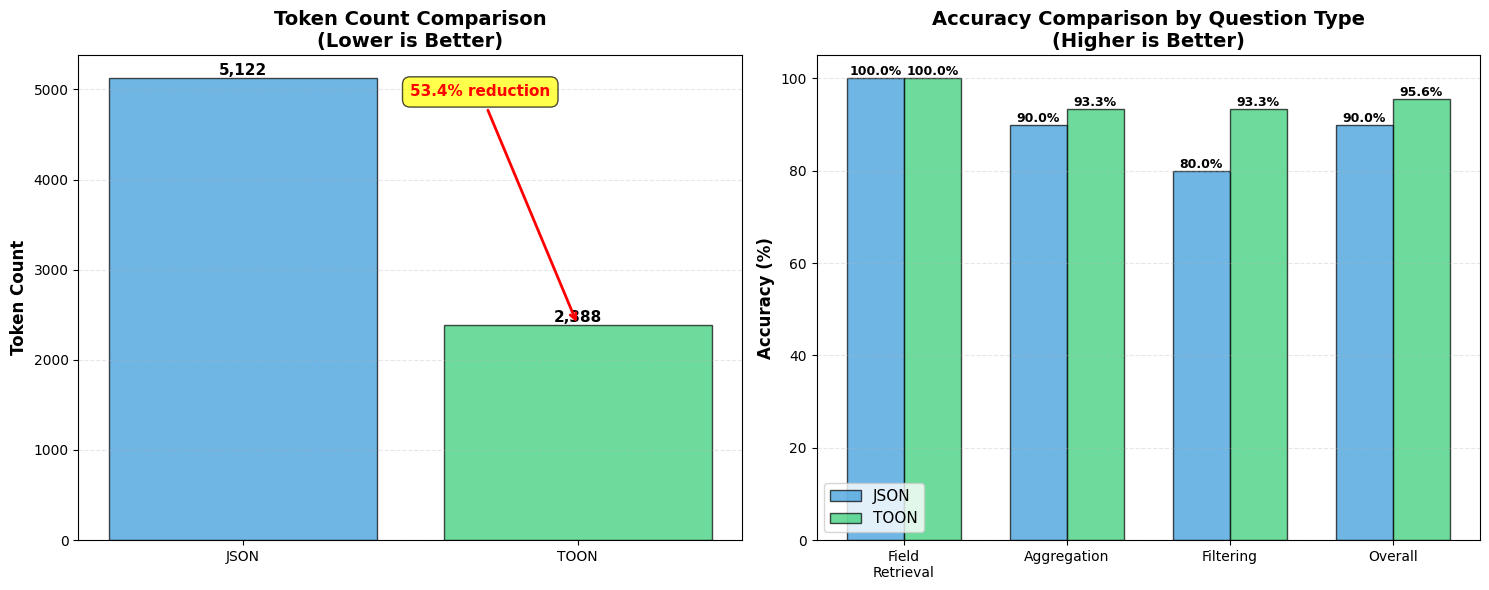

📊 Visualization saved as 'json_vs_toon_comparison.png'


In [101]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate token counts from DataFrames
json_tokens = int(outputs_df_json['input_tokens'].mean())
toon_tokens = int(outputs_df_toon['input_tokens'].mean())
token_reduction = json_tokens - toon_tokens
reduction_percentage = (token_reduction / json_tokens) * 100

# Create figure with two side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ===== SUBPLOT 1: TOKEN COUNT COMPARISON =====
ax1 = axes[0]
formats = ['JSON', 'TOON']
tokens = [json_tokens, toon_tokens]
colors = ['#3498db', '#2ecc71']

# Create bar chart
bars = ax1.bar(formats, tokens, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Token Count', fontsize=12, fontweight='bold')
ax1.set_title('Token Count Comparison\n(Lower is Better)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add reduction annotation with arrow
reduction_text = f'{reduction_percentage:.1f}% reduction'
ax1.annotate(reduction_text, xy=(1, toon_tokens), xytext=(0.5, json_tokens - 200),
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontsize=11, color='red', fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

# ===== SUBPLOT 2: ACCURACY COMPARISON BY TYPE =====
ax2 = axes[1]
question_types = ['Field\nRetrieval', 'Aggregation', 'Filtering', 'Overall']

# Calculate accuracy data from DataFrames for both formats
json_fr_acc = (outputs_df_json[outputs_df_json['type'] == 'field-retrieval']['correct'].sum() / 
               len(outputs_df_json[outputs_df_json['type'] == 'field-retrieval'])) * 100
json_ag_acc = (outputs_df_json[outputs_df_json['type'] == 'aggregation']['correct'].sum() / 
               len(outputs_df_json[outputs_df_json['type'] == 'aggregation'])) * 100
json_ft_acc = (outputs_df_json[outputs_df_json['type'] == 'filtering']['correct'].sum() / 
               len(outputs_df_json[outputs_df_json['type'] == 'filtering'])) * 100
json_overall_acc = (outputs_df_json['correct'].sum() / len(outputs_df_json)) * 100

toon_fr_acc = (outputs_df_toon[outputs_df_toon['type'] == 'field-retrieval']['correct'].sum() / 
               len(outputs_df_toon[outputs_df_toon['type'] == 'field-retrieval'])) * 100
toon_ag_acc = (outputs_df_toon[outputs_df_toon['type'] == 'aggregation']['correct'].sum() / 
               len(outputs_df_toon[outputs_df_toon['type'] == 'aggregation'])) * 100
toon_ft_acc = (outputs_df_toon[outputs_df_toon['type'] == 'filtering']['correct'].sum() / 
               len(outputs_df_toon[outputs_df_toon['type'] == 'filtering'])) * 100
toon_overall_acc = (outputs_df_toon['correct'].sum() / len(outputs_df_toon)) * 100

json_accuracies = [json_fr_acc, json_ag_acc, json_ft_acc, json_overall_acc]
toon_accuracies = [toon_fr_acc, toon_ag_acc, toon_ft_acc, toon_overall_acc]

# Create grouped bar chart
x = np.arange(len(question_types))
width = 0.35

bars1 = ax2.bar(x - width/2, json_accuracies, width, label='JSON', 
                color='#3498db', alpha=0.7, edgecolor='black')
bars2 = ax2.bar(x + width/2, toon_accuracies, width, label='TOON', 
                color='#2ecc71', alpha=0.7, edgecolor='black')

ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Accuracy Comparison by Question Type\n(Higher is Better)', 
              fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(question_types, fontsize=10)
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim(0, 105)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}%',
                 ha='center', va='bottom', fontsize=9, fontweight='bold')

# Save and display
plt.tight_layout()
plt.savefig('json_vs_toon_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Visualization saved as 'json_vs_toon_comparison.png'")

### Step 7: Analyze Error Cases (Optional)

Review questions where the model gave incorrect answers to understand failure patterns.

In [ ]:
# Identify questions where the model gave incorrect answers
json_errors = outputs_df_json[~outputs_df_json['correct']].to_dict('records')
toon_errors = outputs_df_toon[~outputs_df_toon['correct']].to_dict('records')

print(f"🔍 ERROR ANALYSIS:")
print("="*70)
print(f"\nJSON Format: {len(json_errors)} errors out of {len(outputs_df_json)} questions")
print(f"TOON Format: {len(toon_errors)} errors out of {len(outputs_df_toon)} questions")

# ===== SHOW SAMPLE ERRORS FROM JSON FORMAT =====
print(f"\n📝 Sample Errors from JSON Format (first 5):")
print("-"*70)
for i, err in enumerate(json_errors[:5], 1):
    print(f"\n{i}. Question: {err['question']}")
    print(f"   Type: {err['type']}")
    print(f"   Expected: {err['ground_truth']}")
    print(f"   Got: {err['model_response']}")

# ===== SHOW SAMPLE ERRORS FROM TOON FORMAT =====
print(f"\n\n📝 Sample Errors from TOON Format (first 5):")
print("-"*70)
for i, err in enumerate(toon_errors[:5], 1):
    print(f"\n{i}. Question: {err['question']}")
    print(f"   Type: {err['type']}")
    print(f"   Expected: {err['ground_truth']}")
    print(f"   Got: {err['model_response']}")

# ===== ANALYZE DIFFERENTIAL ERRORS =====
# Find questions that failed in one format but not the other
json_error_ids = set(outputs_df_json[~outputs_df_json['correct']]['id'])
toon_error_ids = set(outputs_df_toon[~outputs_df_toon['correct']]['id'])

only_json_errors = json_error_ids - toon_error_ids
only_toon_errors = toon_error_ids - json_error_ids

print(f"\n\n🔄 DIFFERENTIAL ERRORS:")
print("="*70)
print(f"Questions that failed ONLY with JSON: {len(only_json_errors)}")
print(f"Questions that failed ONLY with TOON: {len(only_toon_errors)}")
print(f"Questions that failed with BOTH: {len(json_error_ids & toon_error_ids)}")

🔍 ERROR ANALYSIS:

JSON Format: 9 errors out of 90 questions
TOON Format: 4 errors out of 90 questions

📝 Sample Errors from JSON Format (first 5):
----------------------------------------------------------------------

1. Question: How many employees have a salary greater than 50000?
   Type: aggregation
   Expected: 96
   Got: 97

2. Question: How many employees have a salary greater than 90000?
   Type: aggregation
   Expected: 53
   Got: 52

3. Question: What is the average salary across all employees?
   Type: aggregation
   Expected: 94810
   Got: 94809.89

4. Question: How many employees in Engineering have a salary greater than 90000?
   Type: filtering
   Expected: 8
   Got: 7

5. Question: How many employees in Sales have a salary greater than 90000?
   Type: filtering
   Expected: 10
   Got: 9


📝 Sample Errors from TOON Format (first 5):
----------------------------------------------------------------------

1. Question: How many employees have a salary greater than 90000?
